# Metal Detector Test Data Analysis
48000 SPS (short samples), 16000 Hz transmit freq, output volume maxed on phone (clipping)
## Ground-Only Sweep:

In [1]:
!python "wavefunctions.py"

from wavefunctions import GenerateSinewavePoints, GenerateSinewavePeriods

%matplotlib widget
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from ipywidgets import interact, FloatSlider, IntSlider, Layout
import scipy.signal as signal

plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

sampleRate = 192000

#filename = r"2022_02_21 13_24_24 MST 192000 SPS 16000.0 Hz 20 vol playing (just ground).txt"
#filename = r"2022_02_21 13_24_35 MST 192000 SPS 16000.0 Hz 20 vol playing (quarter 2x).txt"
#filename = r"2022_02_21 13_24_48 MST 192000 SPS 16000.0 Hz 20 vol playing (guard 2x).txt"
#filename = r"2022_02_22 16_09_20 MST 192000 SPS 16000.0 Hz 20 vol playing (snow quarter 5 sec).txt"
#filename = r"2022_02_22 16_09_34 MST 192000 SPS 16000.0 Hz 20 vol playing (snow quarter two snow two).txt"
filename = r"2022_02_22 16_09_47 MST 192000 SPS 16000.0 Hz 20 vol playing (snow four sweeps).txt"

dataFrame = pd.read_csv(filename, header=None)
dataNP = dataFrame.to_numpy()
#dataNPFlat = dataNP.flatten()
dataNPFlat = dataNP[:,0]
print(dataNPFlat.shape)

numPoints = dataNPFlat.shape[0]

x = np.arange(0, numPoints)

fig = plt.figure()

def GeneratePlots2(amplitude, phaseOffset, rangeMin, windowSize):
    if (rangeMin < 0): rangeMin = 0

    print(phaseOffset)
    txWave = GenerateSinewavePoints(sampleRate, 16000, amplitude, phaseOffset, dataNPFlat.shape[0])
    diffWave = dataNPFlat - txWave

    rangeMax = rangeMin+windowSize
    if (rangeMax >= dataNPFlat.shape[0]): rangeMax = dataNPFlat.shape[0]-1
    xInRange = x[rangeMin:rangeMax]

    plt.clf()
    plt.plot(xInRange, dataNPFlat[rangeMin:rangeMax], label="mic samples")
    plt.plot(xInRange, txWave[rangeMin:rangeMax], label="tx wave scaled and offset")
    plt.plot(xInRange, diffWave[rangeMin:rangeMax], label="difference")
    plt.legend()

interact(GeneratePlots2, 
         amplitude=FloatSlider(min=20000, max=22000, step=0.1, value=20900, layout=Layout(width='100%')), 
         phaseOffset=FloatSlider(min=0, max=2*math.pi, step=0.001, value=4.08, layout=Layout(width='100%')),
         rangeMin=IntSlider(min=0, max=numPoints, step=1, value=0, layout=Layout(width='100%')),
         windowSize=IntSlider(min=2, max=10000, step=1, value=50, layout=Layout(width='100%'))
        )

setting up wave functions...
setting up wave functions...


FileNotFoundError: [Errno 2] No such file or directory: '2022_02_22 16_09_47 MST 192000 SPS 16000.0 Hz 20 vol playing (snow four sweeps).txt'

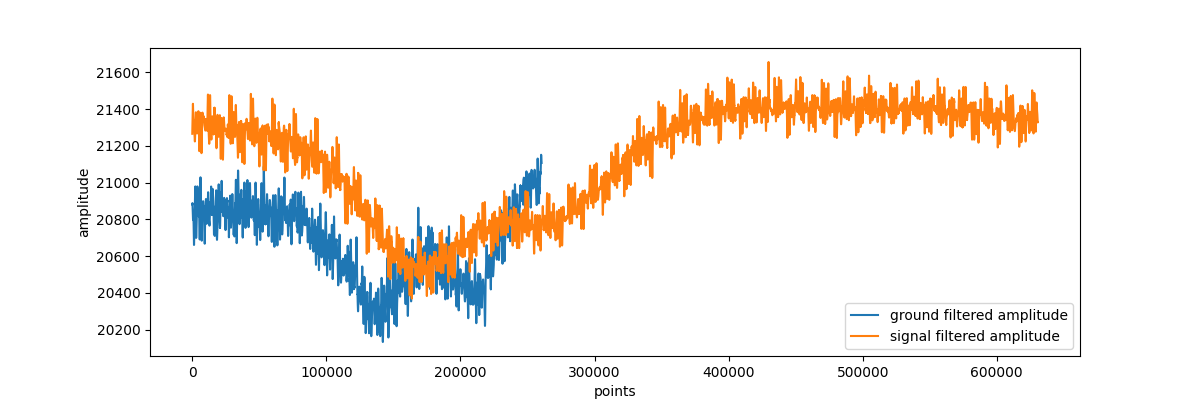

In [2]:
#hilbert transform gives I and Q
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html
analytic_signal = signal.hilbert(dataNPFlat)#returns array of imaginary numbers, where real = I (in-phase) and imaginary = Q (quadrature, 90 deg out of phase)
amplitude_envelope = np.abs(analytic_signal)
#instantaneous_phase = np.unwrap(np.angle(analytic_signal))#this gives a continuously increasing phase angle in radians (somehow), that doesn't wrap when the period ends
#instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * sampleRate)

firFilter = signal.firwin(1001, cutoff = 100, window = "hamming", pass_zero = "lowpass", fs=sampleRate)
dataNPFlatAmplitudeFilt = signal.lfilter(firFilter, 1, amplitude_envelope)

groundData = pd.read_csv(r"2022_02_21 13_24_24 MST 192000 SPS 16000.0 Hz 20 vol playing (just ground).txt", header=None).to_numpy()[:,0]
groundAnalytic = signal.hilbert(groundData)
groundAmplitude = np.abs(groundAnalytic)
groundAmplitudeFiltered = signal.lfilter(firFilter, 1, groundAmplitude)

fig = plt.figure()
plt.plot(groundAmplitudeFiltered[1000:-1], label="ground filtered amplitude")
plt.plot(dataNPFlatAmplitudeFilt[1000:-1], label="signal filtered amplitude")
plt.xlabel('points')
plt.ylabel('amplitude')
plt.axis('tight')
plt.legend()

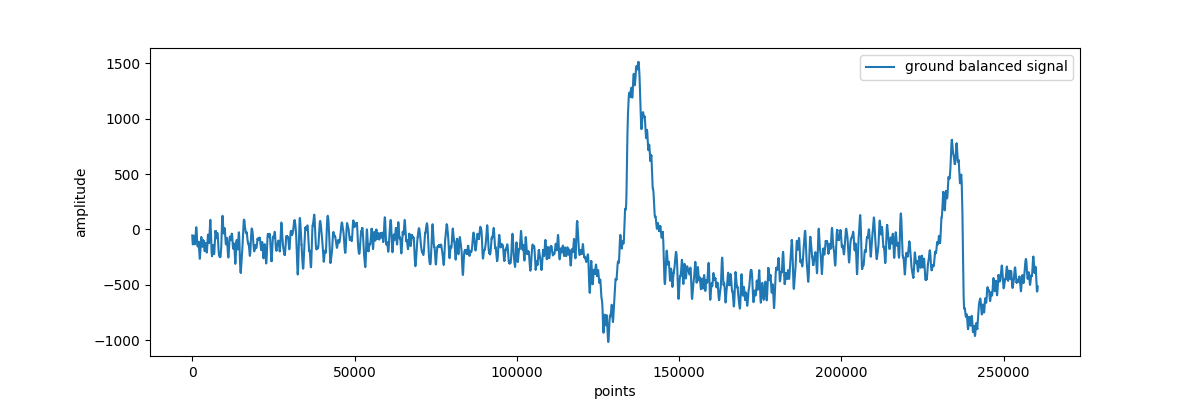

In [12]:
fig = plt.figure()

groundBalancedData = dataNPFlatAmplitudeFilt[0:261534] - groundAmplitudeFiltered[0:261534]

plt.clf()
plt.plot(groundBalancedData[1000:-1], label="ground balanced signal")
plt.xlabel('points')
plt.ylabel('amplitude')
#plt.axis('tight')
plt.legend()

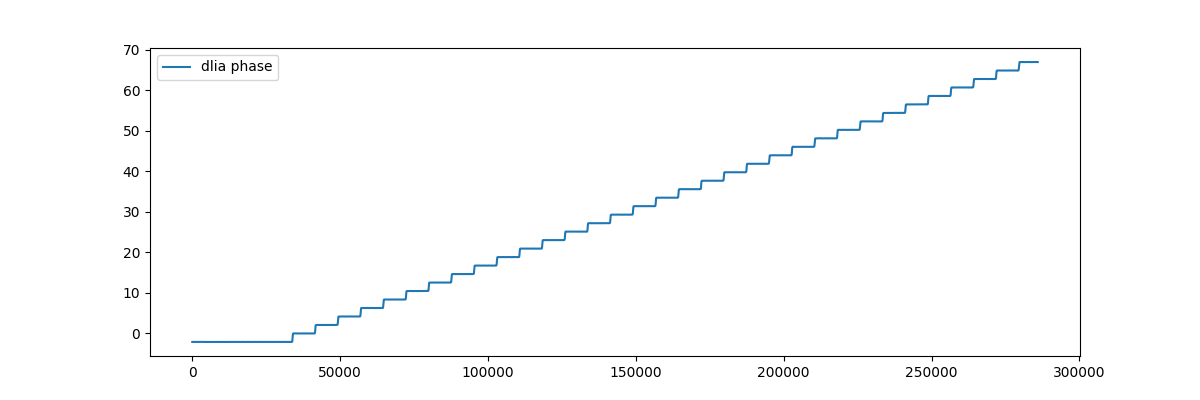

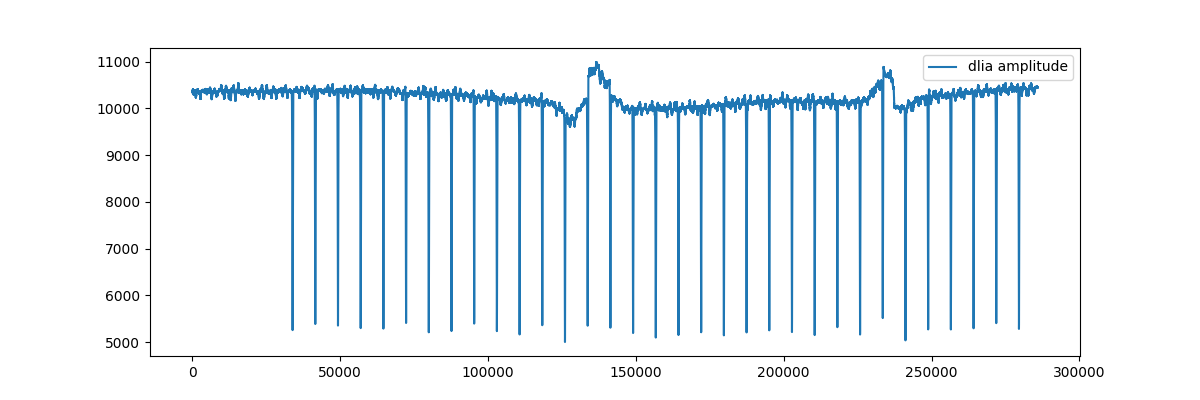

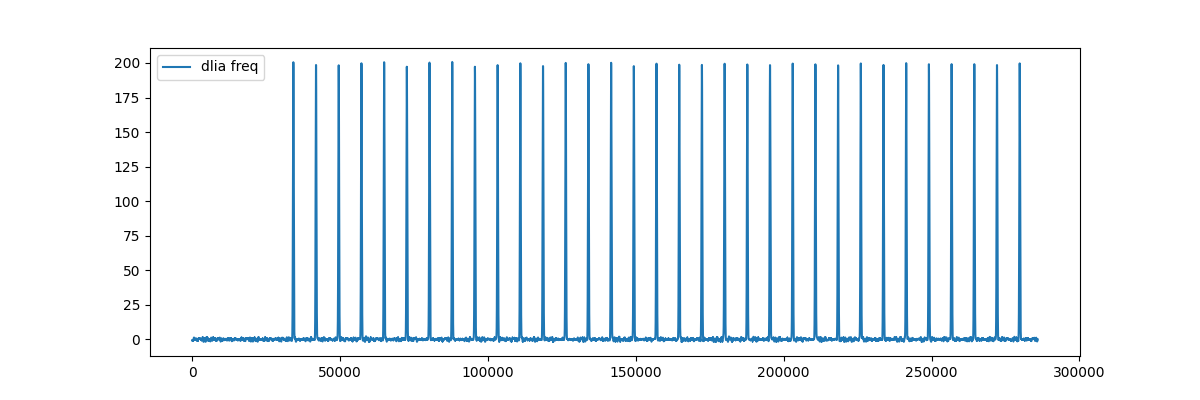

In [13]:
#plt.clf()#try to avoid running out of memory on repeated executions

def NormalizeAngleRad(theta):
    #while (angle < 0): angle += 2*math.pi
    return theta - math.pi*2 * math.floor((theta + math.pi) / (math.pi*2))

def DigitalLockInAmplifier(sampleRate, frequency, inputArray, phaseOffset=0, magOffset=0):
    firFilter = signal.firwin(501, cutoff = 100, window = "hamming", pass_zero = "lowpass", fs=sampleRate)
    
    referenceWaveInPhase = GenerateSinewavePoints(sampleRate, frequency, 1.0, 0, inputArray.size)
    referenceWaveQuadrature = GenerateSinewavePoints(sampleRate, frequency, 1.0, math.pi/2, inputArray.size)
    
    inPhase = referenceWaveInPhase * inputArray
    quadrature = referenceWaveQuadrature * inputArray
    analytic_signal = inPhase + 1j * quadrature
    
    inPhaseFilt = signal.lfilter(firFilter, 1, inPhase)
    quadratureFilt = signal.lfilter(firFilter, 1, quadrature)
    analyticSignalFilt = inPhaseFilt + 1j * quadratureFilt
    
    phaseRad = np.unwrap(np.angle(analyticSignalFilt))
    mag = np.abs(analyticSignalFilt) - magOffset
    #mag = signal.lfilter(firFilter, 1, mag)#works much better than filtering i and q separately before this (??? not so in generated wave testing)
    
    freq = (np.diff(phaseRad) / (2.0*np.pi) * sampleRate)
    freq = signal.lfilter(firFilter, 1, freq)#freq seems to need extra filtering
    
    return (phaseRad, mag, freq)

dliaResults = DigitalLockInAmplifier(sampleRate, 16000, dataNPFlat)
phase = dliaResults[0][1000:-1]
mag = dliaResults[1][1000:-1]
freq = dliaResults[2][1000:-1]

fig = plt.figure()
plt.plot(phase, label="dlia phase")
plt.legend()

fig = plt.figure()
plt.plot(mag, label="dlia amplitude")
plt.legend()

fig = plt.figure()
plt.plot(freq, label="dlia freq")
plt.legend()

I'm seeing periodic spikes in the dlia results that are throwing things off, maybe due to errors in my tx wave transmission or an integer underflow/overflow somewhere.

What seems to be happening is every ~40 ms there is a small freeze or loss in the transmitter or microphone stream then it resumes working.  This problem causes periodic blips in the freq and amplitude plots before they settle, and a stairstep effect of increasing phase angles.  This means the transmitted freq and amplitude are good, there are just time delays every 40 ms for some reason.  Garbage collector, or something in my code maybe?

Todo: try making app with just this plot on android, experiment with what can change or eliminate these spikes

In [24]:
spikePointDiff = 57803 - 50121
spikeTimeDiffSec = 1/sampleRate * spikePointDiff
spikeTimeDiffMs = spikeTimeDiffSec * 1000
print(spikeTimeDiffMs, " [ms]")

spikePointDiff2 = 115518-107847
spikeTimeDiffSec2 = 1/sampleRate * spikePointDiff2
spikeTimeDiffMs2 = spikeTimeDiffSec2 * 1000
print(spikeTimeDiffMs2, " [ms]")

periodTimeSec = 1.0 / 16000.0
periodTimeMs = periodTimeSec*1000
print(periodTimeMs, " period time [ms]")

40.010416666666664  [ms]
39.953125  [ms]
0.0625  period time [ms]
